# Meastasis-Analysis
Analysizing the metastatic lungs we scanned from the Ochsenbein group

In [1]:
import platform
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches
import seaborn
import imageio
import pandas
import numpy
# import numpy.ma
# import scipy.signal
# import sklearn.cluster
# import skimage.filters
# import skimage.transform
# import skimage.morphology
# import skimage.segmentation
# import skimage.color
# import scipy.ndimage
# import math
# from itkwidgets import view  # 3d viewer
# from tqdm import tqdm_notebook

In [2]:
# Ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [4]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [5]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [6]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('S:\\')
Root = os.path.join(BasePath, 'Tuebingen', 'Overview')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Tuebingen\Overview


In [7]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [8]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [9]:
# Get all folders
Data['Folder'] = glob.glob(os.path.join(Root, '*'))

In [10]:
try:
    Data['Folder'][0]
except IndexError:
    print(10 * '\n')
    print('Please mount the Fast SSD!')
    print(10 * '\n')

In [11]:
Data['Sample'] = [os.path.basename(f) for f in Data['Folder']]
Data['SampleNameLength'] = [len(r) for r in Data['Sample']]

In [12]:
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data['Folder']]
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [13]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [14]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s has %04s reconstructions in %s/%s' % (c +1,
                                                             len(Data),
                                                             row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                             row['Number of reconstructions'],
                                                             os.path.basename(row['Folder']),
                                                             'rec'))

 1/6:  07N has    0 reconstructions in 07N/rec
 2/6: 07OP has 1753 reconstructions in 07OP/rec
 3/6:  10N has 1948 reconstructions in 10N/rec
 4/6: 10OP has 2014 reconstructions in 10OP/rec
 5/6:  22N has 1663 reconstructions in 22N/rec
 6/6: 22OP has 1779 reconstructions in 22OP/rec


In [20]:
# Some datasets might not be reconstructed yet.
# Drop those, based on https://stackoverflow.com/a/27360130/323100
Data.drop(Data[Data['Number of reconstructions'] < 1].index, inplace=True)
# Reset index, so we can still count like we used to
Data.reset_index(inplace=True)

In [21]:
# Convert all reconstructions into a single numpy array and them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below, we overwrite the variable with NaN and clear the memory
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
# Do it now      
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameRec']):
        print('%2s/%s: %s: Loading reconstructions from %s' % (c + 1,
                                                               len(Data),
                                                               row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                               row['OutputNameRec']))
        Reconstructions[c] = numpy.load(row['OutputNameRec'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Reading %04s reconstructions' % (c + 1,
                                                            len(Data),
                                                            row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                            row['Number of reconstructions']))
        # https://groups.google.com/forum/#!topic/imageio/O3TjIWKzd5Q
        Reconstructions[c] = numpy.stack([imageio.imread(rec,
                                                         ignoregamma=True) for rec in row['Reconstructions']], 0)
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 6),
                                    row['OutputNameRec'][len(Root):]))
        numpy.save(row['OutputNameRec'], Reconstructions[c], allow_pickle=False)        

 1/5: 07OP: Loading reconstructions from F:\Tuebingen\Overview\07OP\07OP_rec.npy
 2/5:  10N: Loading reconstructions from F:\Tuebingen\Overview\10N\10N_rec.npy
 3/5: 10OP: Loading reconstructions from F:\Tuebingen\Overview\10OP\10OP_rec.npy
 4/5:  22N: Loading reconstructions from F:\Tuebingen\Overview\22N\22N_rec.npy
 5/5: 22OP: Reading 1779 reconstructions
      22OP: Saving to \22OP\22OP_rec.npy


In [22]:
# How big are the datasets?
Data['Size'] = [numpy.shape(rec) for rec in Reconstructions]

In [33]:
# Get ourselves the respective middle images
Data['Mid_Axial'] = [rec[numpy.shape(rec)[0]//2,:,:] for rec in Reconstructions]
Data['Mid_Sagittal'] = [rec[:,numpy.shape(rec)[1]//2,:] for rec in Reconstructions]
Data['Mid_Coronal'] = [rec[:,:,numpy.shape(rec)[2]//2] for rec in Reconstructions]

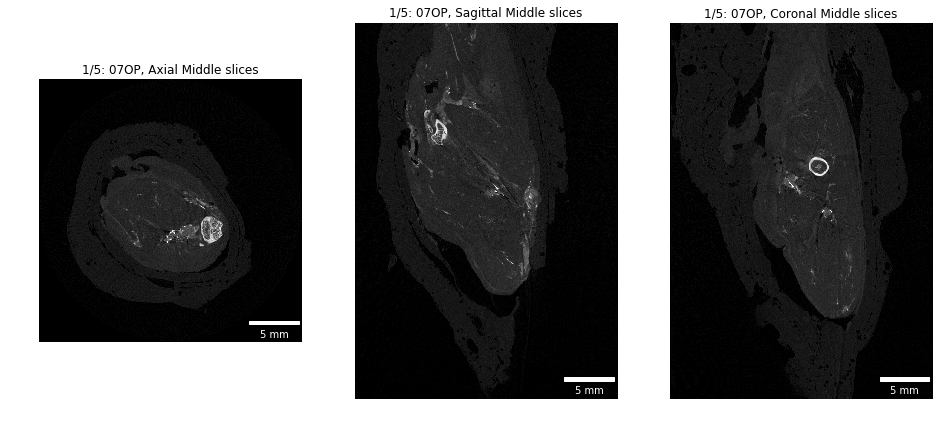

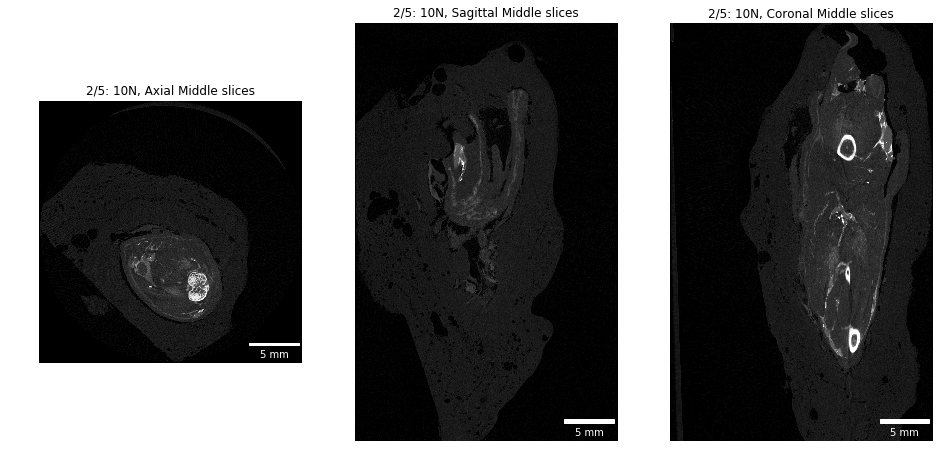

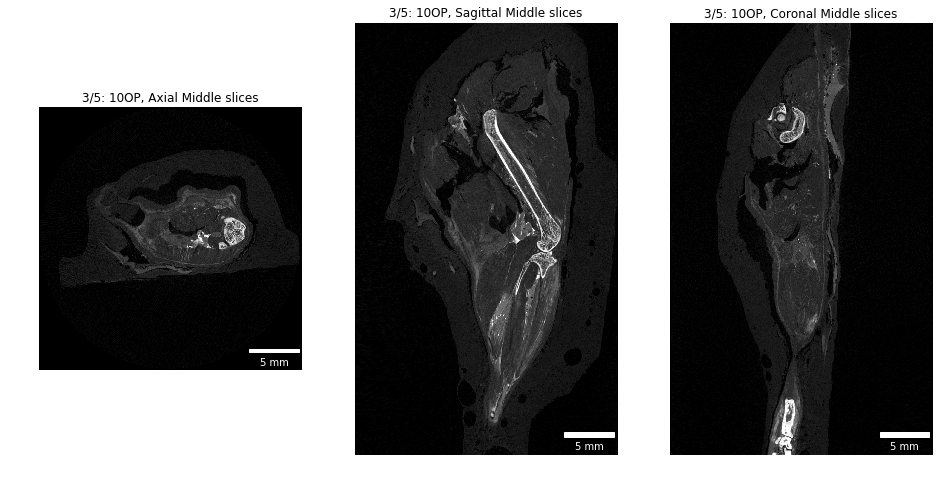

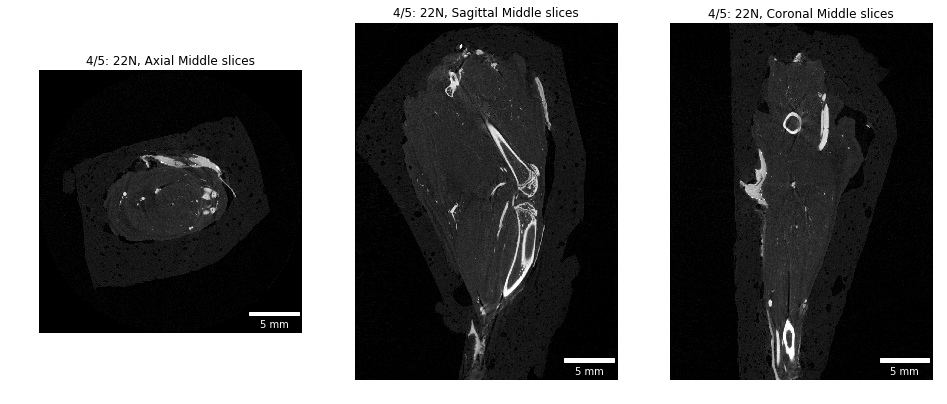

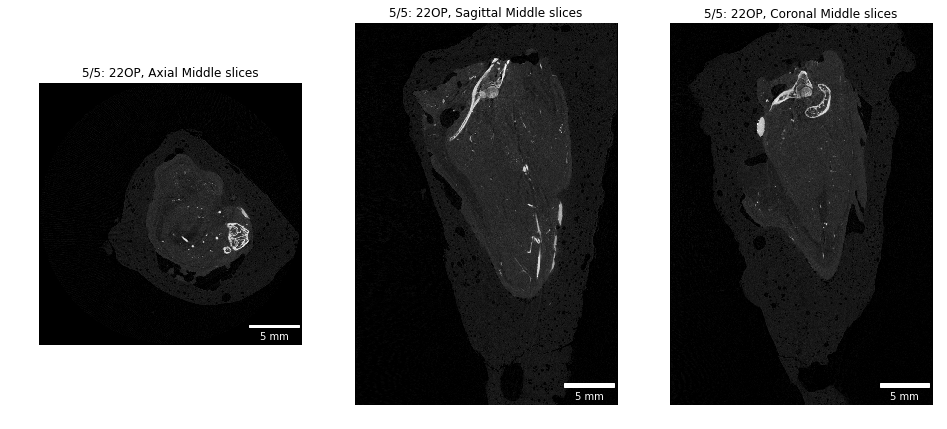

In [48]:
# Show middle slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1,3,d+1)
        plt.imshow(row['Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s' % (c+1,
                                     len(Data),
                                     row['Sample'],
                                     direction + ' Middle slices'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Middle.png'),
                bbox_inches='tight')
    plt.show()

In [41]:
# Calculate MIPs
directions = ['Axial', 'Sagittal', 'Coronal']
for c, direction in enumerate(directions):
    Data['MIP_' + direction] = [numpy.max(rec, axis=c) for rec in Reconstructions]

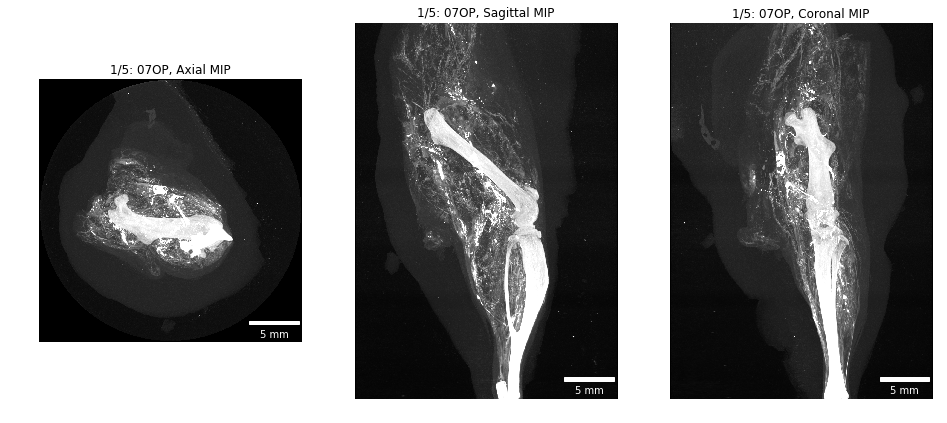

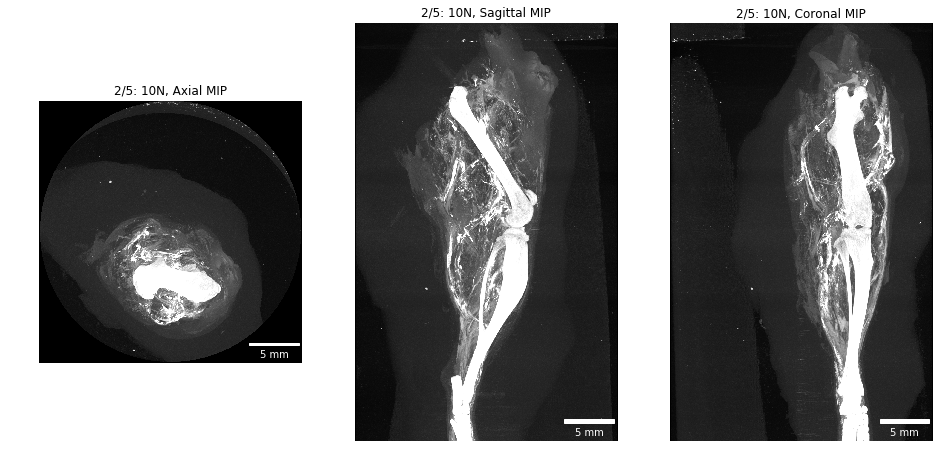

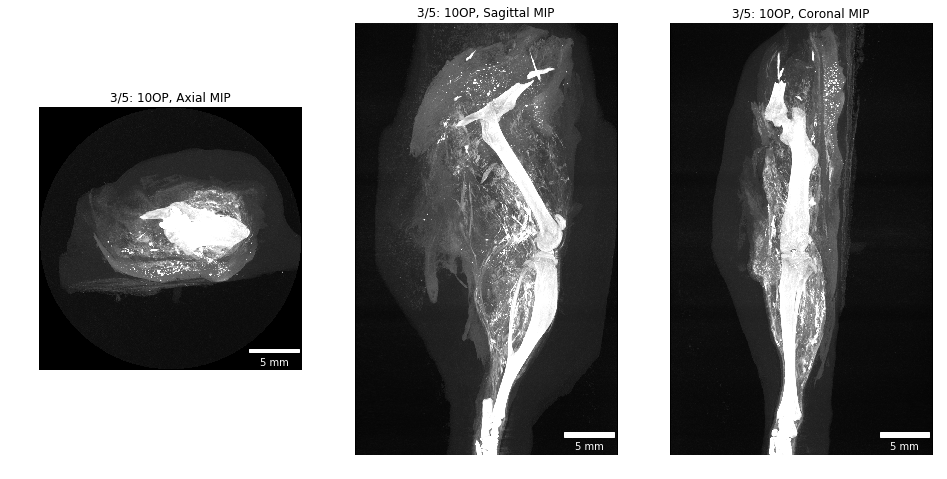

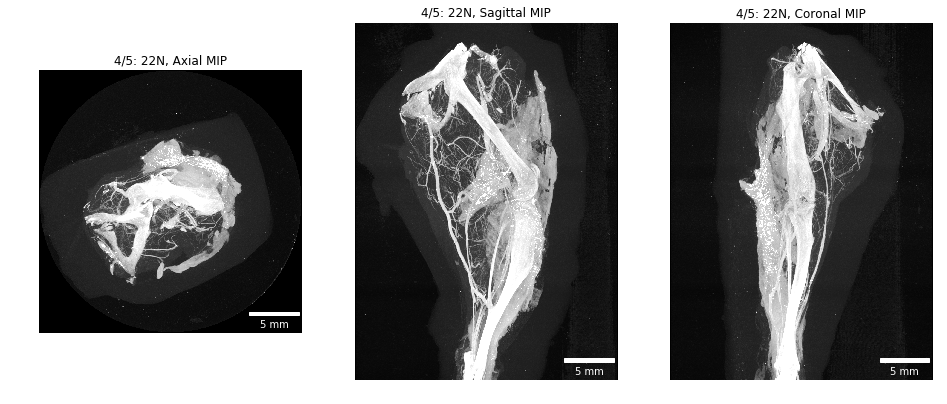

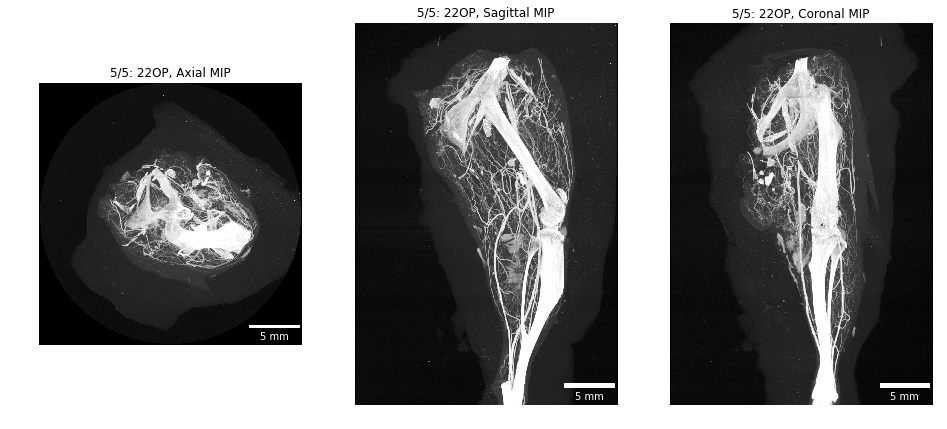

In [47]:
# Show MIP slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1,3,d+1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s' % (c+1,
                                     len(Data),
                                     row['Sample'],
                                     direction + ' MIP'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MIPs.png'),
                bbox_inches='tight')        
    plt.show()

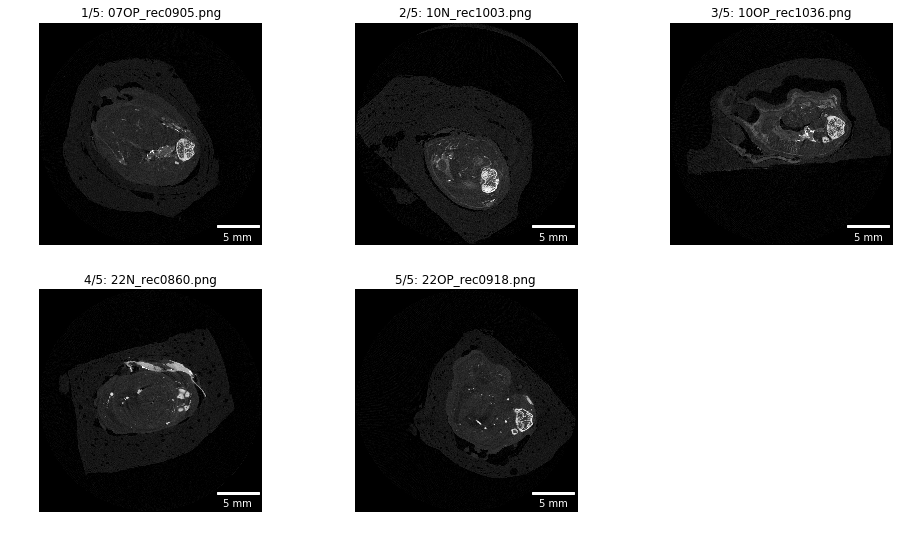

In [34]:
# Show middle axial slice
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row['Mid_Axial'])
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    recname = os.path.basename(row['Reconstructions'][row['Number of reconstructions']//2]).replace('0000', '')
    plt.title('%s/%s: %s' % (c+1,
                             len(Data),
                             recname))
    plt.axis('off')
plt.show()

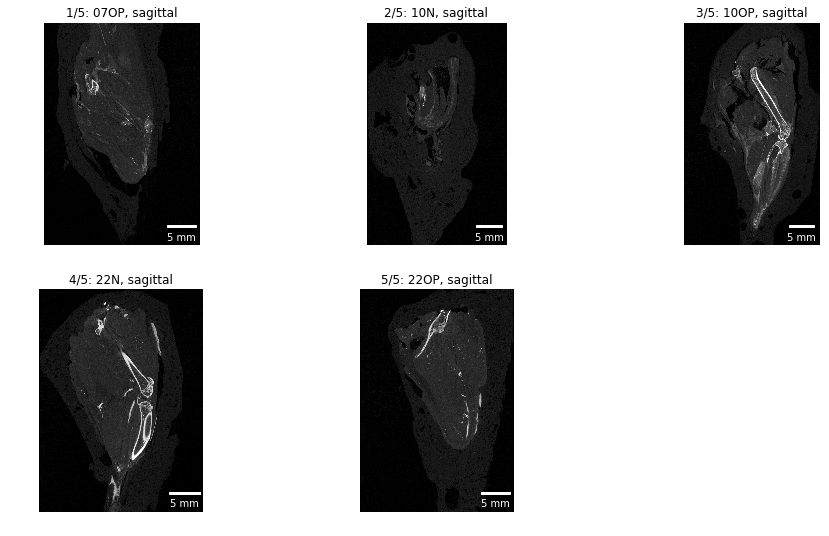

In [37]:
# Show middle sagittal slice
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row['Mid_Sagittal'])
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    recname = os.path.basename(row['Reconstructions'][row['Number of reconstructions']//2]).replace('0000', '')
    plt.title('%s/%s: %s, sagittal' % (c+1,
                                      len(Data),
                                      row['Sample']))
    plt.axis('off')
plt.show()

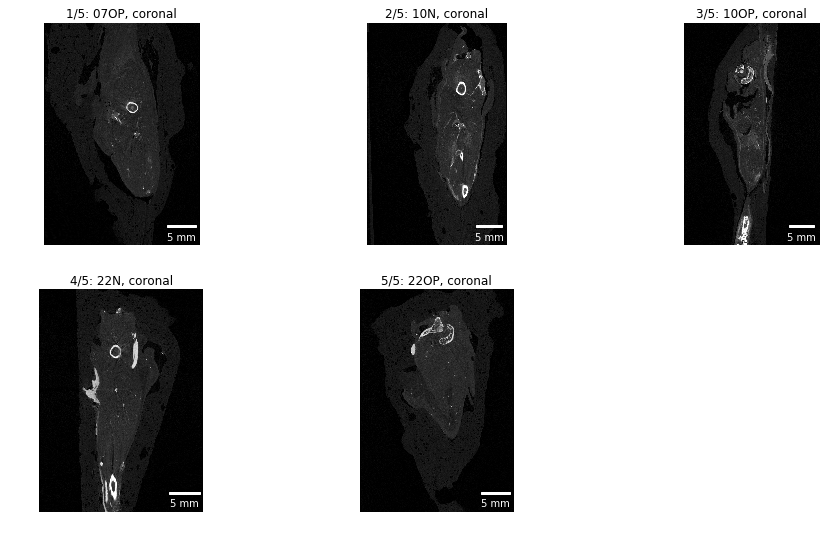

In [36]:
# Show middle coronal slice
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row['Mid_Coronal'])
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.title('%s/%s: %s, coronal' % (c+1,
                                      len(Data),
                                      row['Sample']))
    plt.axis('off')
plt.show()